In [105]:
import numpy as np
import mesh_to_sdf
import trimesh
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import tensorflow as tf

In [106]:
mesh = trimesh.load_mesh("suzanne.obj")
points, dists = mesh_to_sdf.sample_sdf_near_surface(mesh, number_of_points=250000)
points, dists = points/2., dists/2.
print(points.min(), points.max(), points.shape)
print(dists.min(), dists.max(), dists.shape)

-0.49729878 0.4949809 (250000, 3)
-0.20530345 0.34059304 (250000,)


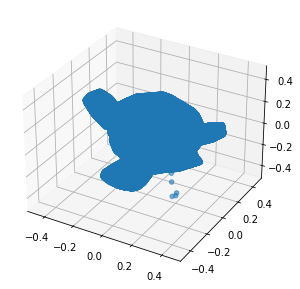

In [107]:
fig =plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim3d(-0.5, 0.5)
ax.set_ylim3d(-0.5, 0.5)
ax.set_zlim3d(-0.5, 0.5)
result = points[dists<0]
ax.scatter(result[:, 0], result[:, 1], result[:, 2]*-1)

In [108]:
def FF(v, N=1024):
    f = np.random.normal(0.0, 3.0, size=(N, v.shape[1])).astype('float32')
    x = np.dot(v, f.T).astype('float32')
    sin = np.sin(2 * np.pi * x).astype('float32')
    cos = np.cos(2 * np.pi * x).astype('float32')
    return np.concatenate([sin, cos], axis=-1), f

In [109]:
ff, f = FF(points)
print(ff.shape)

(250000, 2048)


In [110]:
lr = LinearRegression()
X_train, y_train, X_test, y_test = ff[:200000,...], dists[:200000], ff[200000:,...], dists[200000:,...]
lr.fit(X_train, y_train)

LinearRegression()

In [111]:
y_test.shape

(50000,)

In [112]:
lr.score(X_test, y_test)

-98338.39949876432

In [113]:
def get_dist(points, f, lm):
    x = np.dot(points, f.T).astype('float32')
    sin = np.sin(2 * np.pi * x).astype('float32')
    cos = np.cos(2 * np.pi * x).astype('float32')
    x = np.concatenate([sin, cos], axis=-1)
    return lm.predict(x)

In [114]:
def is_inside(points, f, lm):
    return get_dist(points, f, lm) < 0.0

In [115]:
RESOLUTION = 64
points_pred = np.array(np.mgrid[-0.5:0.5:RESOLUTION*1j,
                           -0.5:0.5:RESOLUTION*1j,
                           -0.5:0.5:RESOLUTION*1j]).T.reshape(-1,3)
print(points.shape)

(250000, 3)


In [122]:
dists_pred = get_dist(points[200000:2000100], f, lr)

In [123]:
print(dists_pred.min(), dists_pred.max())

-250.62051 367.09824


In [76]:
voxels = is_inside(points_pred, f, lr)

In [77]:
voxels.shape

(262144,)

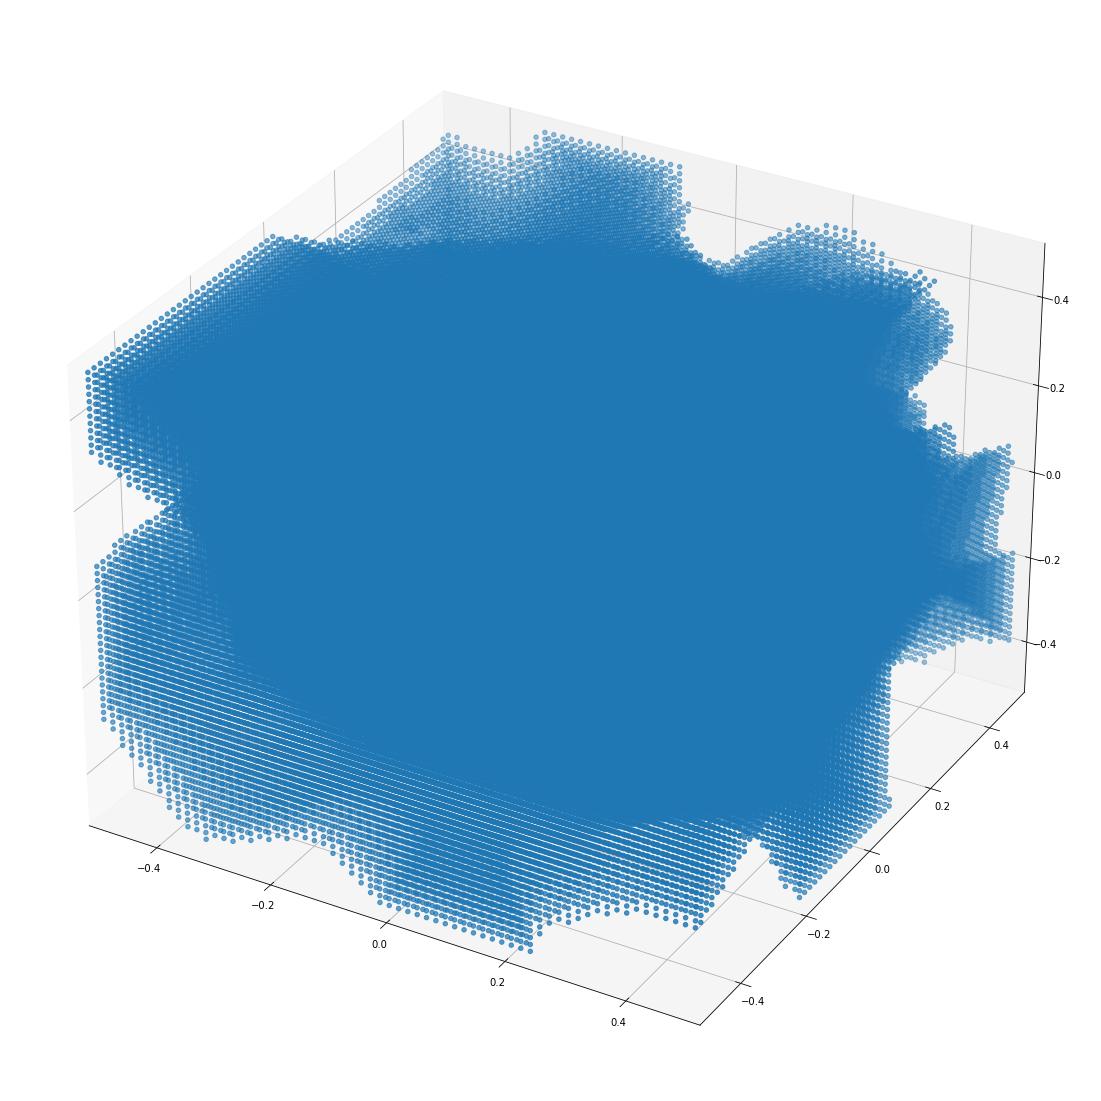

In [ ]:
fig =plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim3d(-0.5, 0.5)
ax.set_ylim3d(-0.5, 0.5)
ax.set_zlim3d(-0.5, 0.5)
result = points_pred[~voxels]
ax.scatter(result[:, 1], result[:, 0], result[:, 2])